In [1]:
import numpy as np
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [2]:
# Define lookup dictionaries
lookup = {}
reverselookup = {}
count = 0

# Base directory for dataset
base_dir = 'D:\\Internships\\Prodigy Infotech\\task4\\archive\\leapGestRecog'

# Iterate through gesture directories
for gesture_dir in os.listdir(os.path.join(base_dir, '00')):
    if not gesture_dir.startswith('.'):
        lookup[gesture_dir] = count
        reverselookup[count] = gesture_dir
        count += 1

print("Lookup Dictionary:")
print(lookup)

Lookup Dictionary:
{'01_palm': 0, '02_l': 1, '03_fist': 2, '04_fist_moved': 3, '05_thumb': 4, '06_index': 5, '07_ok': 6, '08_palm_moved': 7, '09_c': 8, '10_down': 9}


In [3]:
# Load images and labels
x_data = []
y_data = []
datacount = 0

for i in range(10):
    sub_dir = f'0{i}'
    for j in os.listdir(os.path.join(base_dir, sub_dir)):
        if not j.startswith('.'):
            count = 0
            for k in os.listdir(os.path.join(base_dir, sub_dir, j)):
                img_path = os.path.join(base_dir, sub_dir, j, k)
                img = Image.open(img_path)
                img = img.resize((320, 120))
                arr = np.array(img)
                x_data.append(arr)
                count += 1
            y_values = np.full((count, 1), lookup[j])
            y_data.extend(y_values)
            datacount += count

x_data = np.array(x_data, dtype='float32')
y_data = np.array(y_data).reshape(datacount, 1)

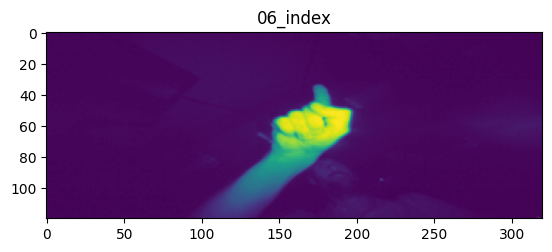

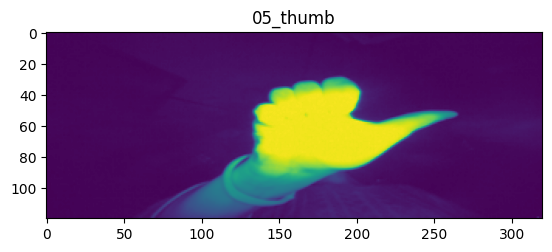

In [4]:
# Display some sample images
num_images = 2
num_samples = len(x_data)
for _ in range(num_images):
    index = random.randint(0, num_samples - 1)
    plt.imshow(x_data[index])
    plt.title(reverselookup[y_data[index, 0]])
    plt.show()


In [5]:
# Preprocess data
x_data = x_data.reshape((x_data.shape[0], 120, 320, 1)) / 255.0
y_data = to_categorical(y_data)

# Split data into train, validation, and test sets
x_train, x_further, y_train, y_further = train_test_split(x_data, y_data, test_size=0.2)
x_validate, x_test, y_validate, y_test = train_test_split(x_further, y_further, test_size=0.5)


In [6]:
# Build the model
model = Sequential([
    Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(120, 320, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

C:\Users\conta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 58, 158, 32)    │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 36, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       737,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 794,954 (3.03 MB)

 Trainable params: 794,954 (3.03 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_weights.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=128, verbose=1, 
                    validation_data=(x_validate, y_validate), 
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.6490 - loss: 1.0250
Epoch 1: val_accuracy improved from -inf to 0.99200, saving model to best_model_weights.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 286ms/step - accuracy: 0.6506 - loss: 1.0203 - val_accuracy: 0.9920 - val_loss: 0.0273
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9968 - loss: 0.0115
Epoch 2: val_accuracy improved from 0.99200 to 0.99800, saving model to best_model_weights.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.9968 - loss: 0.0115 - val_accuracy: 0.9980 - val_loss: 0.0120
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9985 - loss: 0.0059
Epoch 3: val_accuracy improved from 0.99800 to 0.99900, saving model to best_model_weights.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 276ms/step - accuracy: 0.9985 - loss: 0.0059 - val_accuracy: 0.9990 - val_loss: 0.0030
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 1.0000 - loss: 4.5628e

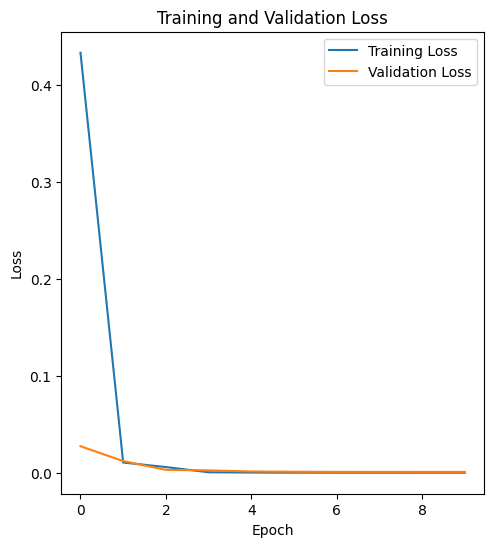

In [10]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

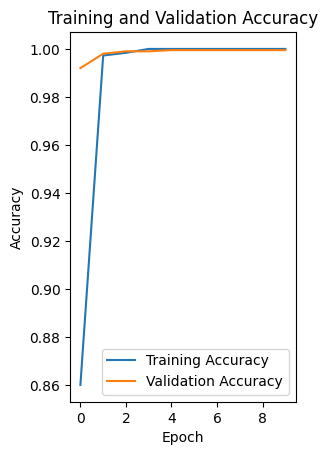

In [11]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [12]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [13]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 1.0000 - loss: 1.4157e-04
Test Loss: 0.0003223816747777164
Test Accuracy: 1.0


In [14]:
# Save the model
model.save('hand_gesture_recognition_model.keras')

In [16]:
#model.save('hand_gesture_recognition_model.h5')

C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


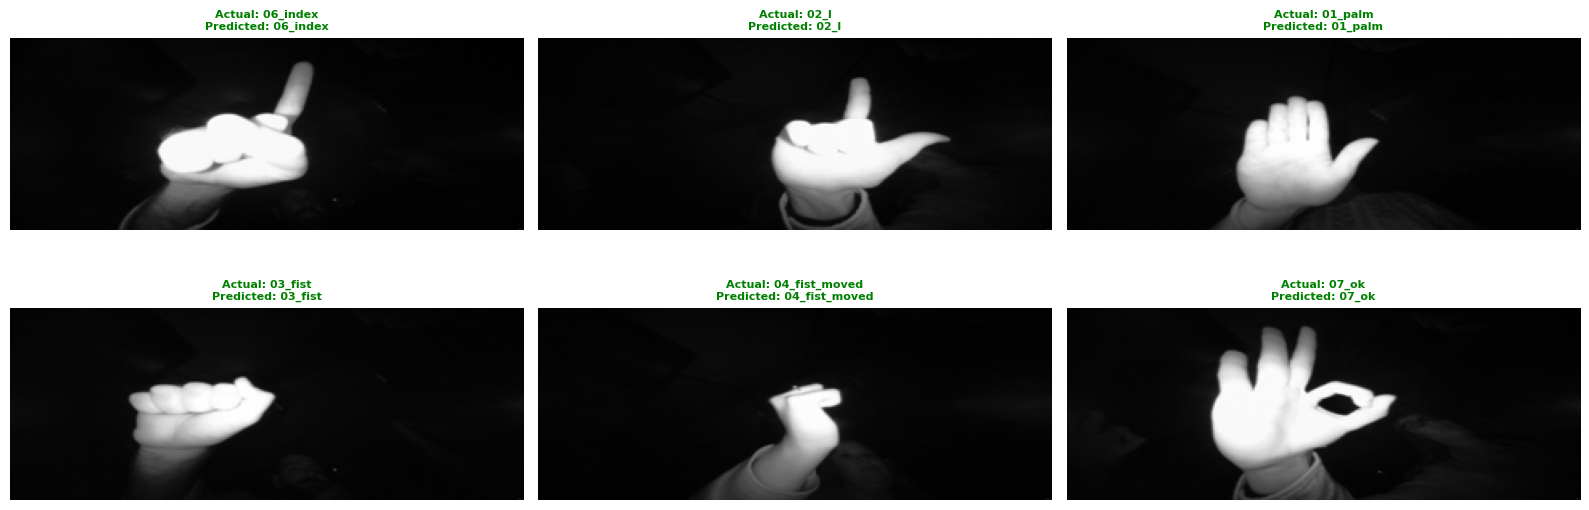

In [15]:
def reverse_lookup(index):
    return reverselookup[index]

num_samples_to_visualize = 6
random_indices = random.sample(range(len(x_test)), num_samples_to_visualize)
x_random_samples = x_test[random_indices]
y_random_labels = y_test[random_indices]
predictions_random = model.predict(x_random_samples)

num_rows = 2
num_cols = num_samples_to_visualize // num_rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 6))

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        sample_image = x_random_samples[index].reshape(120, 320)
        actual_class = np.argmax(y_random_labels[index])
        predicted_class = np.argmax(predictions_random[index])

        title_color = 'green' if predicted_class == actual_class else 'red'
        axes[i, j].imshow(sample_image, cmap='gray')
        axes[i, j].set_title(f'Actual: {reverse_lookup(actual_class)}\nPredicted: {reverse_lookup(predicted_class)}', color=title_color, fontsize=8, fontweight='bold')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()


In [17]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

model = load_model('hand_gesture_recognition_model.keras')
Lookup = {0: '01_palm', 1: '02_l', 2: '03_fist', 3: '04_fist_moved', 4: '05_thumb', 5: '06_index', 6: '07_ok', 7: '08_palm_moved', 8: '09_c', 9: '10_down'}

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized_frame = cv2.resize(gray_frame, (320, 120))
    resized_frame = resized_frame / 255.0
    input_data = np.expand_dims(resized_frame, axis=(0, -1))

    prediction = model.predict(input_data)
    predicted_class_index = np.argmax(prediction)
    predicted_gesture = Lookup[predicted_class_index]

    cv2.putText(frame, predicted_gesture, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Hand Gesture Recognition', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


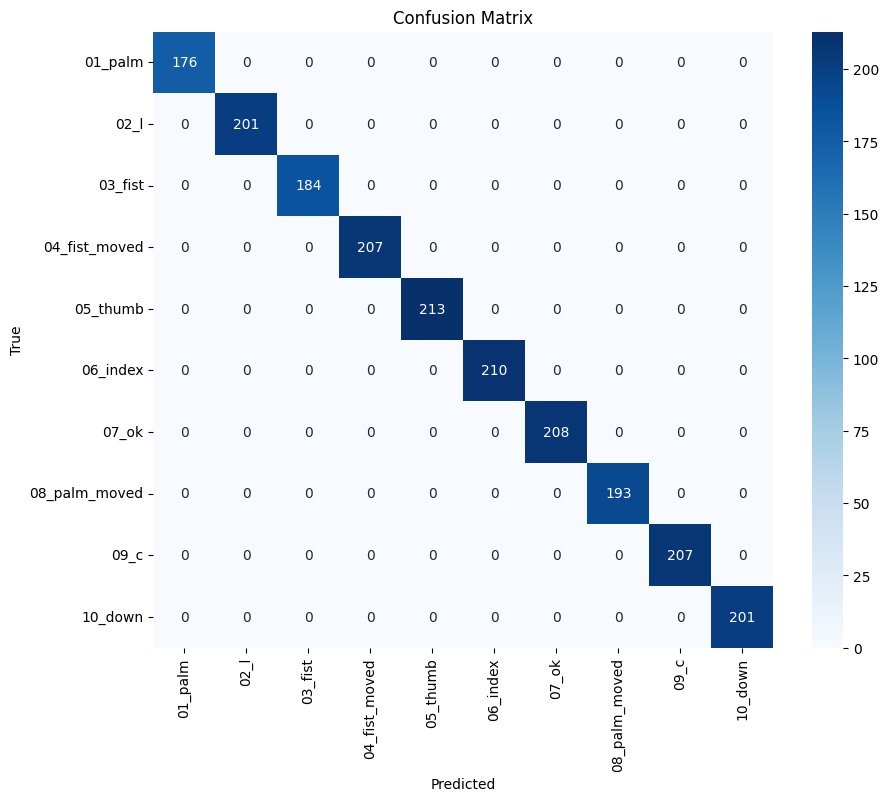

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=[reverse_lookup(i) for i in range(10)], 
            yticklabels=[reverse_lookup(i) for i in range(10)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
